In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os, glob, time, math, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    # Folder with class subfolders
    ROOT_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    IMAGE_EXTS: Tuple[str,...] = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")

    img_size: int = 224
    batch_size: int = 32
    epochs: int = 50

    # Kaggle/Colab-friendly dataloader
    num_workers: int = 0
    pin_memory: bool = False

    # Optim / BYOL
    lr: float = 3e-4
    weight_decay: float = 1e-4
    ema_base_m: float = 0.996
    proj_dim: int = 256
    hidden_dim: int = 4096

    seed: int = 42

    # t-SNE options
    MAX_TSNE_IMAGES: Optional[int] = 1500   # reduce if slow/OOM; set None for all images
    TSNE_COLOR_BY_LABELS: bool = True       # color by TRUE labels & save 'byol_tsne_by_label.png'

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# Unlabeled BYOL Dataset
# -----------------------
class TwoViewTransform:
    """BYOL-style strong augmentations (two stochastic views)."""
    def __init__(self, size):
        self.t = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.2,0.1)], p=0.8),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __call__(self, img):
        return self.t(img), self.t(img)

class UnlabeledRecursive(Dataset):
    """Recursively collects image paths; returns two augmented views; NO labels."""
    def __init__(self, root, size, exts):
        self.paths: List[str] = []
        for ext in exts:
            self.paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found under: {root}")
        self.view = TwoViewTransform(size)
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        with Image.open(p) as im:
            img = im.convert("RGB")
        v1, v2 = self.view(img)
        return v1, v2

train_ds = UnlabeledRecursive(cfg.ROOT_TRAIN, cfg.img_size, cfg.IMAGE_EXTS)
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    drop_last=True
)

# -----------------------
# BYOL Model
# -----------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out, bias=False),
            nn.BatchNorm1d(out, affine=False)
        )
    def forward(self, x): return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden, bias=False),
            nn.BatchNorm1d(hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, dim)
        )
    def forward(self, x): return self.net(x)

def get_backbone():
    enc = models.resnet50(weights=None)  # from scratch; swap if desired
    feat = enc.fc.in_features
    enc.fc = nn.Identity()               # global pool -> 2048-d features
    return enc, feat

class BYOL(nn.Module):
    def __init__(self, proj_dim=256, hidden=4096):
        super().__init__()
        self.online_enc, feat = get_backbone()
        self.online_proj = ProjectionHead(feat, hidden, proj_dim)
        self.online_pred = PredictionHead(proj_dim, hidden)

        self.target_enc, _ = get_backbone()
        self.target_proj = ProjectionHead(feat, hidden, proj_dim)

        # init target as EMA copy of online
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.copy_(s.data); t.requires_grad = False
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.copy_(s.data); t.requires_grad = False

    @torch.no_grad()
    def update_target(self, m):
        for t, s in zip(self.target_enc.parameters(), self.online_enc.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)
        for t, s in zip(self.target_proj.parameters(), self.online_proj.parameters()):
            t.data.mul_(m).add_(s.data, alpha=1-m)

    def forward(self, x1, x2, m):
        # online
        q1 = self.online_pred(self.online_proj(self.online_enc(x1)))
        q2 = self.online_pred(self.online_proj(self.online_enc(x2)))
        # target (no grad)
        with torch.no_grad():
            k1 = self.target_proj(self.target_enc(x1))
            k2 = self.target_proj(self.target_enc(x2))
        # normalize
        q1 = F.normalize(q1, dim=-1); q2 = F.normalize(q2, dim=-1)
        k1 = F.normalize(k1, dim=-1); k2 = F.normalize(k2, dim=-1)
        # BYOL loss
        def byol_loss(a, b): return 2 - 2*(a*b).sum(dim=-1).mean()
        loss = byol_loss(q1, k2) + byol_loss(q2, k1)
        self.update_target(m)
        return loss

def momentum_schedule(m0, epoch, max_epochs):
    return 1 - (1-m0)*(0.5*(1+math.cos(math.pi*epoch/max_epochs)))

model = BYOL(cfg.proj_dim, cfg.hidden_dim).to(device)
optimizer = torch.optim.AdamW([
    {"params": model.online_enc.parameters()},
    {"params": model.online_proj.parameters()},
    {"params": model.online_pred.parameters()},
], lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def lr_at(e):
    base, final = cfg.lr, cfg.lr*0.01
    if cfg.epochs <= 1: return base
    t = e/(cfg.epochs-1)
    return final + (base-final)*0.5*(1+math.cos(math.pi*t))

# -----------------------
# Train
# -----------------------
loss_history = []

for epoch in range(cfg.epochs):
    for pg in optimizer.param_groups:
        pg["lr"] = lr_at(epoch)
    m = momentum_schedule(cfg.ema_base_m, epoch, cfg.epochs)

    model.train()
    running, t0 = 0.0, time.time()
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{cfg.epochs}")
    for v1, v2 in pbar:
        v1 = v1.to(device, non_blocking=False); v2 = v2.to(device, non_blocking=False)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            loss = model(v1, v2, m)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

        running += loss.item()
        avg = running / (pbar.n if pbar.n > 0 else 1)
        pbar.set_postfix({"loss": f"{avg:.4f}"})
    loss_history.append(avg)
    print(f"Epoch {epoch+1}/{cfg.epochs} | avg_loss={avg:.4f} | time={time.time()-t0:.1f}s")

# Save encoder for downstream tasks
torch.save(model.online_enc.state_dict(), "byol_encoder.pth")
print("✅ BYOL pretrained encoder saved as 'byol_encoder.pth'")


/tmp/ipykernel_36/2139249034.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/50:   0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_36/2139249034.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/50 | avg_loss=3.0879 | time=176.2s


Epoch 2/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/50 | avg_loss=2.0723 | time=168.2s


Epoch 3/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/50 | avg_loss=1.6604 | time=171.4s


Epoch 4/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/50 | avg_loss=1.3975 | time=168.3s


Epoch 5/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/50 | avg_loss=1.2407 | time=167.9s


Epoch 6/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/50 | avg_loss=1.2539 | time=172.1s


Epoch 7/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/50 | avg_loss=1.3892 | time=170.9s


Epoch 8/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/50 | avg_loss=1.5462 | time=168.8s


Epoch 9/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/50 | avg_loss=1.6841 | time=168.0s


Epoch 10/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/50 | avg_loss=1.8137 | time=170.5s


Epoch 11/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/50 | avg_loss=1.8477 | time=166.3s


Epoch 12/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/50 | avg_loss=1.7878 | time=165.0s


Epoch 13/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/50 | avg_loss=1.8525 | time=168.3s


Epoch 14/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/50 | avg_loss=1.8498 | time=169.0s


Epoch 15/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/50 | avg_loss=1.8354 | time=166.7s


Epoch 16/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/50 | avg_loss=1.7851 | time=165.1s


Epoch 17/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/50 | avg_loss=1.7113 | time=169.0s


Epoch 18/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/50 | avg_loss=1.6903 | time=172.1s


Epoch 19/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/50 | avg_loss=1.6510 | time=167.7s


Epoch 20/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/50 | avg_loss=1.6495 | time=166.0s


Epoch 21/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/50 | avg_loss=1.5848 | time=169.4s


Epoch 22/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/50 | avg_loss=1.5926 | time=163.6s


Epoch 23/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/50 | avg_loss=1.5083 | time=167.6s


Epoch 24/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/50 | avg_loss=1.4312 | time=166.8s


Epoch 25/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/50 | avg_loss=1.4558 | time=171.6s


Epoch 26/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 26/50 | avg_loss=1.3538 | time=167.8s


Epoch 27/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 27/50 | avg_loss=1.3092 | time=171.2s


Epoch 28/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 28/50 | avg_loss=1.3431 | time=168.7s


Epoch 29/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 29/50 | avg_loss=1.2698 | time=169.5s


Epoch 30/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 30/50 | avg_loss=1.2850 | time=167.5s


Epoch 31/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 31/50 | avg_loss=1.2718 | time=169.4s


Epoch 32/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 32/50 | avg_loss=1.1821 | time=172.1s


Epoch 33/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 33/50 | avg_loss=1.2645 | time=169.0s


Epoch 34/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 34/50 | avg_loss=1.2506 | time=168.5s


Epoch 35/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 35/50 | avg_loss=1.1892 | time=172.3s


Epoch 36/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 36/50 | avg_loss=1.1235 | time=169.4s


Epoch 37/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 37/50 | avg_loss=1.1659 | time=173.2s


Epoch 38/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 38/50 | avg_loss=1.2025 | time=167.6s


Epoch 39/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 39/50 | avg_loss=1.1141 | time=163.7s


Epoch 40/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 40/50 | avg_loss=1.1502 | time=168.3s


Epoch 41/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 41/50 | avg_loss=1.1172 | time=168.2s


Epoch 42/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 42/50 | avg_loss=1.1501 | time=167.9s


Epoch 43/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 43/50 | avg_loss=1.1486 | time=164.4s


Epoch 44/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 44/50 | avg_loss=1.1451 | time=169.1s


Epoch 45/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 45/50 | avg_loss=1.0503 | time=165.5s


Epoch 46/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 46/50 | avg_loss=1.1167 | time=165.3s


Epoch 47/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 47/50 | avg_loss=1.1563 | time=169.9s


Epoch 48/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 48/50 | avg_loss=1.0528 | time=168.2s


Epoch 49/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 49/50 | avg_loss=1.1238 | time=162.4s


Epoch 50/50:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch 50/50 | avg_loss=1.1622 | time=167.4s
✅ BYOL pretrained encoder saved as 'byol_encoder.pth'


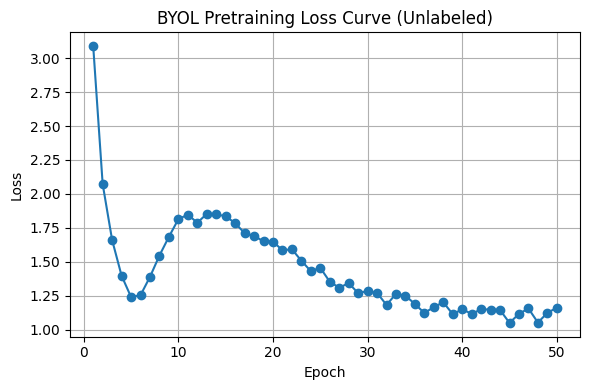

📈 Loss curve saved as 'byol_loss_curve.png'


In [2]:
# Plot & save loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("BYOL Pretraining Loss Curve (Unlabeled)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.tight_layout()
plt.savefig("byol_loss_curve.png", dpi=300)
plt.show()
print("📈 Loss curve saved as 'byol_loss_curve.png'")

🔍 Running t-SNE on learned embeddings...


Embedding (labeled):   0%|          | 0/47 [00:00<?, ?it/s]

Embeddings shape: (1500, 2048)


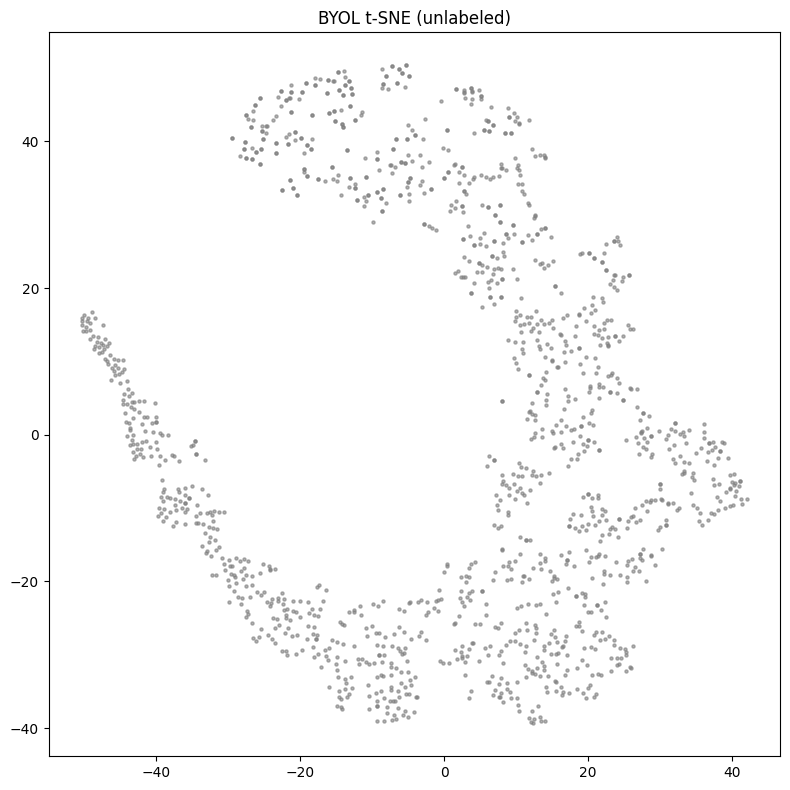

💾 Saved: byol_tsne.png


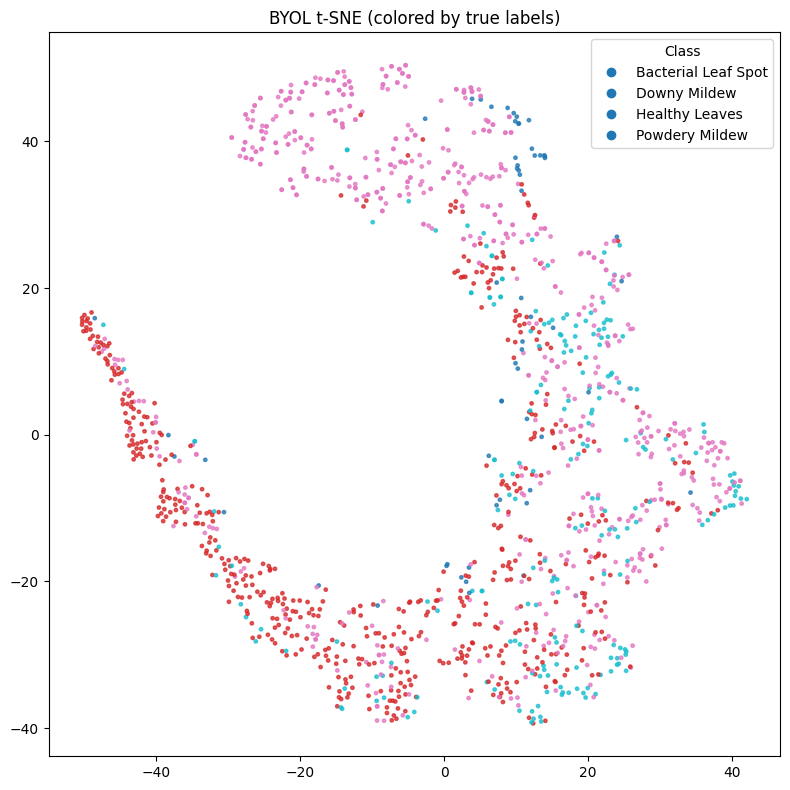

💾 Saved: byol_tsne_by_label.png


In [3]:
# -----------------------
# t-SNE Visualization
# -----------------------
print("🔍 Running t-SNE on learned embeddings...")

base_eval_tfms = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# If TSNE_COLOR_BY_LABELS=True, use ImageFolder (yields (img, label)); else build unlabeled dataset.
if cfg.TSNE_COLOR_BY_LABELS:
    full_ds = datasets.ImageFolder(cfg.ROOT_TRAIN, transform=base_eval_tfms)
else:
    class SingleViewUnlabeled(Dataset):
        def __init__(self, root, exts, transform):
            self.paths = []
            for ext in exts:
                self.paths.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
            if len(self.paths) == 0:
                raise RuntimeError(f"No images found under: {root}")
            self.t = transform
        def __len__(self): return len(self.paths)
        def __getitem__(self, i):
            with Image.open(self.paths[i]) as im:
                return self.t(im.convert("RGB"))
    full_ds = SingleViewUnlabeled(cfg.ROOT_TRAIN, cfg.IMAGE_EXTS, base_eval_tfms)

# Limit for t-SNE to avoid OOM
n = len(full_ds)
if cfg.MAX_TSNE_IMAGES is not None and n > cfg.MAX_TSNE_IMAGES:
    idx = np.random.choice(n, cfg.MAX_TSNE_IMAGES, replace=False)
    tsne_ds = Subset(full_ds, idx.tolist())
else:
    tsne_ds = full_ds

tsne_loader = DataLoader(
    tsne_ds,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory
)

# Extract embeddings (batched)
model.online_enc.eval()
all_feats = []
all_labels = [] if cfg.TSNE_COLOR_BY_LABELS else None

with torch.no_grad():
    if cfg.TSNE_COLOR_BY_LABELS:
        for imgs, labels in tqdm(tsne_loader, desc="Embedding (labeled)"):
            feats = model.online_enc(imgs.to(device)).detach().cpu().numpy()
            all_feats.append(feats)
            all_labels.append(labels.numpy())
        labels_np = np.concatenate(all_labels, axis=0) if all_labels is not None else None
    else:
        for imgs in tqdm(tsne_loader, desc="Embedding (unlabeled)"):
            feats = model.online_enc(imgs.to(device)).detach().cpu().numpy()
            all_feats.append(feats)
        labels_np = None

feats = np.concatenate(all_feats, axis=0)
print(f"Embeddings shape: {feats.shape}")

# t-SNE to 2D
tsne = TSNE(n_components=2, init='random', perplexity=30, random_state=cfg.seed)
feats_2d = tsne.fit_transform(feats)

# --- Unlabeled t-SNE plot ---
plt.figure(figsize=(8,8))
plt.scatter(feats_2d[:,0], feats_2d[:,1], s=5, alpha=0.6, c='gray')
plt.title("BYOL t-SNE (unlabeled)")
plt.tight_layout()
plt.savefig("byol_tsne.png", dpi=300)
plt.show()
print("💾 Saved: byol_tsne.png")

# --- Plot clusters colored by TRUE labels ---
if cfg.TSNE_COLOR_BY_LABELS and labels_np is not None:
    plt.figure(figsize=(8,8))
    sc = plt.scatter(
        feats_2d[:, 0], feats_2d[:, 1],
        s=6, alpha=0.75, c=labels_np, cmap='tab10'
    )

    # Build legend using class names from ImageFolder (even when wrapped in Subset)
    ds_for_names = getattr(tsne_ds, 'dataset', tsne_ds)
    while isinstance(ds_for_names, Subset):
        ds_for_names = ds_for_names.dataset
    if hasattr(ds_for_names, 'classes'):
        class_names = ds_for_names.classes
        uniq = np.unique(labels_np)
        handles = [plt.Line2D([0],[0], marker='o', linestyle='', markersize=6, label=class_names[i])
                   for i in uniq]
        plt.legend(handles=handles, title="Class", loc="best")
    else:
        # Fallback generic legend
        legend_handles, legend_labels = sc.legend_elements()
        plt.legend(legend_handles, legend_labels, title="Class", loc="best")

    plt.title("BYOL t-SNE (colored by true labels)")
    plt.tight_layout()
    plt.savefig("byol_tsne_by_label.png", dpi=300)
    plt.show()
    print("💾 Saved: byol_tsne_by_label.png")


In [12]:
# ============================
# Downstream Fine-tuning (Train + Validation) with tidy epoch printouts
# ============================
# - Loads BYOL encoder from /kaggle/working/byol_encoder.pth
# - Adds linear head, fine-tunes on labeled train/validate
# - Shows tqdm bars that reach 100% and prints a clean per-epoch summary
# - After 50 epochs, prints FINAL Train & Validation accuracy
# - Saves fine-tuned model + Train vs Validation plots

import os, time, math, random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
@dataclass
class CFG:
    PATH_TRAIN: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
    PATH_VALID: str = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
    ENCODER_PATH: str = "/kaggle/working/byol_encoder.pth"  # BYOL-pretrained encoder

    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 0       # keep 0 in notebooks to avoid multiprocessing warnings
    pin_memory: bool = False

    epochs: int = 50
    lr: float = 1e-3
    weight_decay: float = 1e-4
    warmup_epochs: int = 1
    freeze_epochs: int = 1     # freeze encoder for first N epochs, then unfreeze
    label_smoothing: float = 0.0
    seed: int = 42

cfg = CFG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Reproducibility
# -----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
set_seed(cfg.seed)

# -----------------------
# Data
# -----------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(cfg.PATH_TRAIN, transform=train_tf)
valid_ds = datasets.ImageFolder(cfg.PATH_VALID, transform=eval_tf)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)
valid_loader = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=cfg.pin_memory)

# -----------------------
# Model: load BYOL encoder, attach linear head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)
    feat_dim = enc.fc.in_features  # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

encoder, feat_dim = build_resnet50_encoder()
state = torch.load(cfg.ENCODER_PATH, map_location="cpu")
missing, unexpected = encoder.load_state_dict(state, strict=False)
print("Loaded BYOL encoder. Missing keys:", missing, "| Unexpected:", unexpected)

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

model = Classifier(encoder, feat_dim, num_classes).to(device)

# Freeze encoder initially (head warmup)
def set_encoder_trainable(m, on: bool):
    for p in m.parameters(): p.requires_grad = on
set_encoder_trainable(model.encoder, False)

def make_optimizer(lr):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.AdamW(params, lr=lr, weight_decay=cfg.weight_decay)

optimizer = make_optimizer(cfg.lr)
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing).to(device)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def lr_at(epoch, max_epochs, base_lr, warmup_epochs=0, final_scale=0.05):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / max(1, warmup_epochs)
    t = (epoch - warmup_epochs) / max(1, max_epochs - warmup_epochs - 1)
    return base_lr * (final_scale + 0.5 * (1 - final_scale) * (1 + math.cos(math.pi * t)))

# -----------------------
# Tidy, fixed-length tqdm bars
# -----------------------
BAR_FMT = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"

def run_epoch(loader, train: bool, desc: str):
    model.train() if train else model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    pbar = tqdm(total=len(loader), desc=desc, leave=True, miniters=1, dynamic_ncols=True, bar_format=BAR_FMT)
    with torch.set_grad_enabled(train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
            pbar.set_postfix(loss=f"{(total_loss/total):.4f}", acc=f"{(total_correct/total)*100:.2f}%")
            pbar.update(1)
    pbar.close()
    return total_loss/total, total_correct/total  # avg loss, accuracy

# -----------------------
# Training loop (50 epochs)
# -----------------------
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(cfg.epochs):
    # Unfreeze encoder after warmup
    if epoch == cfg.freeze_epochs:
        set_encoder_trainable(model.encoder, True)
        optimizer = make_optimizer(cfg.lr * 0.3)  # smaller LR after unfreeze

    # Update LR
    lr_now = lr_at(epoch, cfg.epochs, optimizer.param_groups[0]["lr"], warmup_epochs=cfg.warmup_epochs)
    for pg in optimizer.param_groups: pg["lr"] = lr_now

    # Bars + epoch summary
    tr_loss, tr_acc = run_epoch(train_loader, train=True,  desc=f"Epoch {epoch+1}/{cfg.epochs} (Train)")
    va_loss, va_acc = run_epoch(valid_loader, train=False, desc=f"Epoch {epoch+1}/{cfg.epochs} (Valid)")

    train_losses.append(tr_loss); valid_losses.append(va_loss)
    train_accs.append(tr_acc);    valid_accs.append(va_acc)

    # Clean epoch summary line (matches your example style)
    print(f"Epoch {epoch+1}: Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

# -----------------------
# Final accuracies
# -----------------------
final_train_acc = train_accs[-1] * 100.0
final_val_acc   = valid_accs[-1] * 100.0
print(f"\n✅ Final Train Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%\n")

# -----------------------
# Save fine-tuned model
# -----------------------
torch.save(model.state_dict(), "finetuned_classifier.pth")
print("💾 Fine-tuned model saved as 'finetuned_classifier.pth'")




Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded BYOL encoder. Missing keys: [] | Unexpected: []


/tmp/ipykernel_36/3327002228.py:122: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipykernel_36/3327002228.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.0835, Train Acc: 0.5739, Val Loss: 1.1723, Val Acc: 0.5379


Epoch 2/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.7511, Train Acc: 0.7096, Val Loss: 0.4586, Val Acc: 0.8411


Epoch 3/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.5431, Train Acc: 0.7956, Val Loss: 0.4226, Val Acc: 0.8191


Epoch 4/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.4264, Train Acc: 0.8527, Val Loss: 0.2520, Val Acc: 0.9364


Epoch 5/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3514, Train Acc: 0.8721, Val Loss: 0.4041, Val Acc: 0.8460


Epoch 6/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.2831, Train Acc: 0.9004, Val Loss: 0.4287, Val Acc: 0.8557


Epoch 7/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.2650, Train Acc: 0.9078, Val Loss: 0.3651, Val Acc: 0.8484


Epoch 8/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.2555, Train Acc: 0.9161, Val Loss: 0.2029, Val Acc: 0.9340


Epoch 9/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.1891, Train Acc: 0.9371, Val Loss: 0.1300, Val Acc: 0.9658


Epoch 10/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.1695, Train Acc: 0.9366, Val Loss: 0.2190, Val Acc: 0.9193


Epoch 11/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 11/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.1621, Train Acc: 0.9486, Val Loss: 0.2337, Val Acc: 0.9046


Epoch 12/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 12/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.1474, Train Acc: 0.9507, Val Loss: 0.2441, Val Acc: 0.9095


Epoch 13/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 13/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.1272, Train Acc: 0.9570, Val Loss: 0.1671, Val Acc: 0.9511


Epoch 14/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 14/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.1096, Train Acc: 0.9670, Val Loss: 0.1838, Val Acc: 0.9340


Epoch 15/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 15/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.0994, Train Acc: 0.9670, Val Loss: 0.1930, Val Acc: 0.9291


Epoch 16/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 16/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.1011, Train Acc: 0.9607, Val Loss: 0.2401, Val Acc: 0.9095


Epoch 17/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 17/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.0779, Train Acc: 0.9748, Val Loss: 0.1565, Val Acc: 0.9364


Epoch 18/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 18/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.0764, Train Acc: 0.9748, Val Loss: 0.1286, Val Acc: 0.9487


Epoch 19/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 19/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.0613, Train Acc: 0.9790, Val Loss: 0.1599, Val Acc: 0.9389


Epoch 20/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 20/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.0567, Train Acc: 0.9822, Val Loss: 0.1391, Val Acc: 0.9389


Epoch 21/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 21/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.0622, Train Acc: 0.9811, Val Loss: 0.1620, Val Acc: 0.9315


Epoch 22/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 22/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.0530, Train Acc: 0.9811, Val Loss: 0.1652, Val Acc: 0.9462


Epoch 23/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 23/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.0456, Train Acc: 0.9858, Val Loss: 0.1414, Val Acc: 0.9413


Epoch 24/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 24/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.0504, Train Acc: 0.9811, Val Loss: 0.1535, Val Acc: 0.9413


Epoch 25/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 25/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.0472, Train Acc: 0.9848, Val Loss: 0.1432, Val Acc: 0.9438


Epoch 26/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 26/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.0516, Train Acc: 0.9843, Val Loss: 0.1623, Val Acc: 0.9364


Epoch 27/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 27/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.0535, Train Acc: 0.9827, Val Loss: 0.1507, Val Acc: 0.9413


Epoch 28/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 28/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.0459, Train Acc: 0.9838, Val Loss: 0.1508, Val Acc: 0.9389


Epoch 29/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 29/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.0467, Train Acc: 0.9838, Val Loss: 0.1528, Val Acc: 0.9389


Epoch 30/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 30/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.0423, Train Acc: 0.9874, Val Loss: 0.1474, Val Acc: 0.9413


Epoch 31/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 31/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31: Train Loss: 0.0423, Train Acc: 0.9895, Val Loss: 0.1456, Val Acc: 0.9413


Epoch 32/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 32/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32: Train Loss: 0.0423, Train Acc: 0.9864, Val Loss: 0.1624, Val Acc: 0.9315


Epoch 33/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 33/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33: Train Loss: 0.0455, Train Acc: 0.9848, Val Loss: 0.1403, Val Acc: 0.9438


Epoch 34/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 34/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34: Train Loss: 0.0497, Train Acc: 0.9801, Val Loss: 0.1752, Val Acc: 0.9315


Epoch 35/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 35/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35: Train Loss: 0.0509, Train Acc: 0.9838, Val Loss: 0.1333, Val Acc: 0.9462


Epoch 36/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 36/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36: Train Loss: 0.0449, Train Acc: 0.9848, Val Loss: 0.1526, Val Acc: 0.9389


Epoch 37/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 37/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37: Train Loss: 0.0439, Train Acc: 0.9869, Val Loss: 0.1490, Val Acc: 0.9413


Epoch 38/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 38/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.0436, Train Acc: 0.9843, Val Loss: 0.1360, Val Acc: 0.9438


Epoch 39/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 39/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39: Train Loss: 0.0498, Train Acc: 0.9822, Val Loss: 0.1454, Val Acc: 0.9413


Epoch 40/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 40/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40: Train Loss: 0.0511, Train Acc: 0.9858, Val Loss: 0.1399, Val Acc: 0.9462


Epoch 41/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 41/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41: Train Loss: 0.0396, Train Acc: 0.9874, Val Loss: 0.1472, Val Acc: 0.9413


Epoch 42/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 42/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42: Train Loss: 0.0520, Train Acc: 0.9785, Val Loss: 0.1482, Val Acc: 0.9413


Epoch 43/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 43/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43: Train Loss: 0.0524, Train Acc: 0.9848, Val Loss: 0.1536, Val Acc: 0.9438


Epoch 44/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 44/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44: Train Loss: 0.0430, Train Acc: 0.9874, Val Loss: 0.1475, Val Acc: 0.9413


Epoch 45/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 45/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45: Train Loss: 0.0446, Train Acc: 0.9832, Val Loss: 0.1410, Val Acc: 0.9389


Epoch 46/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 46/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46: Train Loss: 0.0389, Train Acc: 0.9858, Val Loss: 0.1468, Val Acc: 0.9413


Epoch 47/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 47/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47: Train Loss: 0.0419, Train Acc: 0.9895, Val Loss: 0.1411, Val Acc: 0.9413


Epoch 48/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 48/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48: Train Loss: 0.0508, Train Acc: 0.9848, Val Loss: 0.1612, Val Acc: 0.9413


Epoch 49/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 49/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49: Train Loss: 0.0470, Train Acc: 0.9869, Val Loss: 0.1523, Val Acc: 0.9413


Epoch 50/50 (Train):   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 50/50 (Valid):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50: Train Loss: 0.0356, Train Acc: 0.9895, Val Loss: 0.1513, Val Acc: 0.9389

✅ Final Train Accuracy: 98.95%
✅ Final Validation Accuracy: 93.89%

💾 Fine-tuned model saved as 'finetuned_classifier.pth'


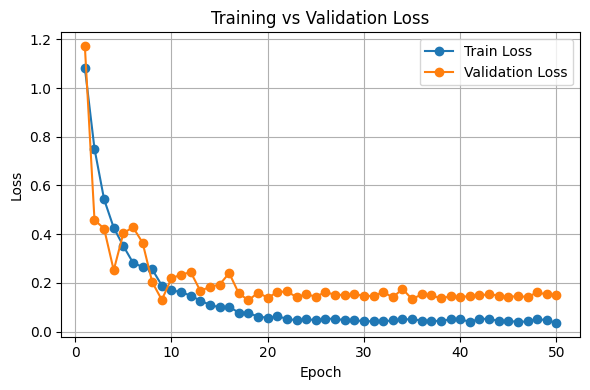

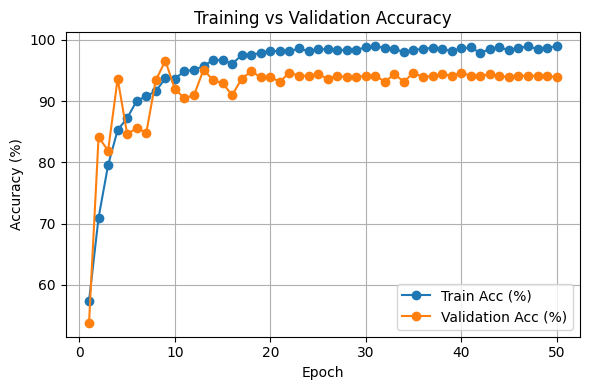

In [13]:
# -----------------------
# Plots: Train vs Validation
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, cfg.epochs+1), valid_losses, marker='o', label='Validation Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_loss.png", dpi=300); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, cfg.epochs+1), [a*100 for a in train_accs], marker='o', label='Train Acc (%)')
plt.plot(range(1, cfg.epochs+1), [a*100 for a in valid_accs], marker='o', label='Validation Acc (%)')
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Training vs Validation Accuracy")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("train_val_acc.png", dpi=300); plt.show()

In [14]:
# ========= 2.4 Downstream Fine-tuning — LAST PART: TEST EVALUATION =========
# Uses fine-tuned model weights: /kaggle/working/finetuned_classifier.pth

import os, time, itertools, math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.preprocessing import label_binarize

# -----------------------
# Paths & config
# -----------------------
FINETUNED_PATH = "/kaggle/working/finetuned_classifier.pth"
PATH_TEST = "/kaggle/input/datasetleaf77/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = False
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# -----------------------
# Data (test only)
# -----------------------
mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = datasets.ImageFolder(PATH_TEST, transform=eval_tf)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# -----------------------
# Rebuild model exactly like fine-tuning: encoder + linear head
# -----------------------
def build_resnet50_encoder():
    enc = models.resnet50(weights=None)
    feat_dim = enc.fc.in_features  # 2048
    enc.fc = nn.Identity()
    return enc, feat_dim

class Classifier(nn.Module):
    def __init__(self, encoder, feat_dim, n_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(feat_dim, n_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)

encoder, feat_dim = build_resnet50_encoder()
model = Classifier(encoder, feat_dim, num_classes).to(device)

# Load fine-tuned weights
state = torch.load(FINETUNED_PATH, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded fine-tuned model. Missing keys:", missing, "| Unexpected:", unexpected)

# -----------------------
# Helper: collect logits/targets
# -----------------------
@torch.no_grad()
def collect_logits_targets(loader):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y)
    return torch.cat(all_logits), torch.cat(all_targets)

# -----------------------
# TEST EVALUATION + timing
# -----------------------
t_test_start = time.time()
test_logits, test_targets = collect_logits_targets(test_loader)
t_test_end = time.time()
test_time_sec = t_test_end - t_test_start

test_probs = torch.softmax(test_logits, dim=1).numpy()
test_preds = test_logits.argmax(dim=1).numpy()
test_targets_np = test_targets.numpy()

# Overall Test Accuracy
test_acc = accuracy_score(test_targets_np, test_preds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"⏱️ Testing time: {test_time_sec:.1f} seconds")




Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']
Loaded fine-tuned model. Missing keys: [] | Unexpected: []

✅ Test Accuracy: 91.44%
⏱️ Testing time: 6.2 seconds


Class 'Bacterial Leaf Spot': accuracy = 86.67%
Class 'Downy Mildew': accuracy = 93.79%
Class 'Healthy Leaves': accuracy = 99.47%
Class 'Powdery Mildew': accuracy = 62.30%

Classification Report (per-class):
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.72      0.87      0.79        15
       Downy Mildew       0.93      0.94      0.93       145
     Healthy Leaves       0.94      0.99      0.96       188
     Powdery Mildew       0.86      0.62      0.72        61

           accuracy                           0.91       409
          macro avg       0.86      0.86      0.85       409
       weighted avg       0.91      0.91      0.91       409

Macro   Precision/Recall/F1: 0.862 / 0.856 / 0.852
Micro   Precision/Recall/F1: 0.914 / 0.914 / 0.914
Weighted Precision/Recall/F1: 0.913 / 0.914 / 0.910


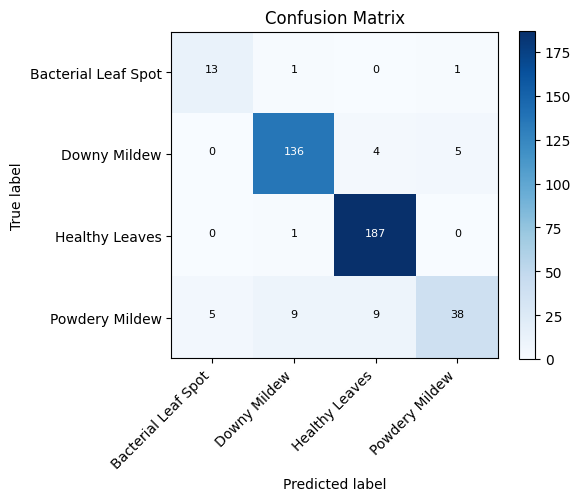

🖼️ Saved 'confusion_matrix.png'


In [15]:
# Per-class Accuracy
cm = confusion_matrix(test_targets_np, test_preds, labels=list(range(num_classes)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
for i, cname in enumerate(class_names):
    print(f"Class '{cname}': accuracy = {per_class_acc[i]*100:.2f}%")

# Precision / Recall / F1 (macro, micro, weighted) + per-class table
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='macro', zero_division=0)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='micro', zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    test_targets_np, test_preds, average='weighted', zero_division=0)

from sklearn.metrics import classification_report
print("\nClassification Report (per-class):")
print(classification_report(test_targets_np, test_preds, target_names=class_names, zero_division=0))

print(f"Macro   Precision/Recall/F1: {prec_macro:.3f} / {rec_macro:.3f} / {f1_macro:.3f}")
print(f"Micro   Precision/Recall/F1: {prec_micro:.3f} / {rec_micro:.3f} / {f1_micro:.3f}")
print(f"Weighted Precision/Recall/F1: {prec_weighted:.3f} / {rec_weighted:.3f} / {f1_weighted:.3f}")




# -----------------------
# Confusion Matrix plot
# -----------------------
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=8)
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300); plt.show()
print("🖼️ Saved 'confusion_matrix.png'")


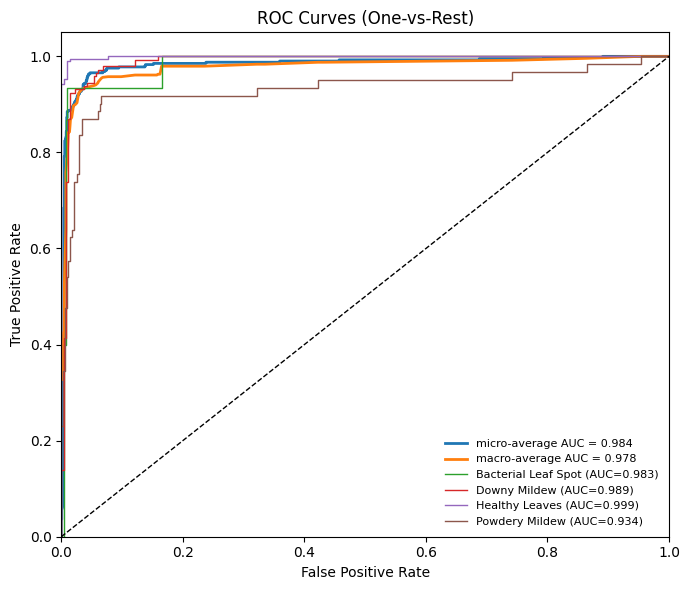

🖼️ Saved 'roc_auc_curves.png'


In [16]:
# -----------------------
# ROC curves + AUC (One-vs-Rest)
# -----------------------
# Binarize labels for ROC/AUC
y_true_bin = label_binarize(test_targets_np, classes=list(range(num_classes)))
if y_true_bin.shape[1] == 1:
    # In binary case, expand to 2 columns for ROC plotting
    y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

fpr = {}; tpr = {}; roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), test_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average AUC = {roc_auc['micro']:.3f}", linewidth=2)
plt.plot(all_fpr, mean_tpr, label=f"macro-average AUC = {roc_auc['macro']:.3f}", linewidth=2)
for i, cname in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{cname} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(fontsize=8, loc="lower right", frameon=False)
plt.tight_layout()
plt.savefig("roc_auc_curves.png", dpi=300); plt.show()
print("🖼️ Saved 'roc_auc_curves.png'")


